In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.linalg import orthogonal_procrustes
from sklearn.metrics import mean_squared_error
from helpers_pmf import *

In [3]:
mu = 0.0 
sigma_u = 1.0
sigma_v = 1.0
sigma = 0.2 
parameters = {}
d_dims = 2 

__generate__ matrices U, V and R from Gauss. distributions

In [503]:
def generate_U_V_R(mu, sigma_U, sigma_V, sigma, n_users, n_movies):
    U = np.random.normal(mu, sigma_U, size=(d_dims,n_users))
    V = np.random.normal(mu, sigma_V, size=(d_dims,n_movies))
    noise = np.random.normal(mu, sigma, size=(n_users,n_movies)) 
    R = np.matmul(U.T,V) +noise
    return U, V, R

We will now initialise our parameters. First the $V$ matrix can be initialised randomly using the following distribution:

\begin{equation}
\large
V \sim \mathcal N\left(0, \frac {1} {\lambda_V}\right)
\end{equation}

Let's remember that:

\begin{equation}
\large
U \in \mathbb R^{D\times N}, \qquad V \in \mathbb R^{D\times M}
\end{equation}

Where $N$ is __n_users__, $M$ is __n_movies__ and $D$ is __n_dims__.

In [504]:
def initialize_parameters(sigma_U, sigma_V, mu, sigma, n_users, n_movies):    
    U, V, R = generate_U_V_R(mu, sigma_U, sigma_V, sigma, n_users, n_movies) 
    U_init = np.random.normal(mu, sigma_U, (d_dims, n_users))
    V_init = np.random.normal(mu, sigma_V, (d_dims, n_movies))    
    
    parameters['U'] = U
    parameters['V'] = V
    parameters['R'] = R
    parameters['U_result'] = U_init
    parameters['V_result'] = V_init
    parameters['lambda_U'] = sigma**2/sigma_U**2
    parameters['lambda_V'] = sigma**2/sigma_V**2

create __ratings__ dataframe and append rating matrix

In [505]:
def create_rating_df(n_users, n_movies):   
    #initialize_parameters(sigma_u/sigma, sigma_v/sigma, mu, sigma, n_users, n_movies)
    
    df = pd.DataFrame(columns=['userID', 'movieID'])
    df['userID'] = np.repeat(np.arange(1, n_users+1, 1), n_movies)
    df['movieID'] = np.tile(np.arange(1, n_movies+1, 1), n_users) 
    
    R = parameters['R']
    df['rating'] = R.reshape(n_users*n_movies)
    
    return df 

__split__ the dataset into train and test sets

In [506]:
def split_train_test(df, train_size=0.75):
    
    df_copy = df.copy()
    train_set = df_copy.sample(frac=train_size, random_state=0)
    test_set = df_copy.drop(train_set.index)
    
    return train_set, test_set
     

Let's now implement the function that updates U and V. The elements of both matrices can be updated using the following expressions:

\begin{equation}
\large
U_i=\left[\left(V_jV_j^T\right)_{j\in\Omega_{U_i}}+\lambda_UI\right]^{-1}\left(R_{ij}V_j^T\right)_{j\in\Omega_{U_i}}
\end{equation}

\begin{equation}
\large
V_j=\left[\left(U_iU_i^T\right)_{i\in\Omega_{V_j}}+\lambda_VI\right]^{-1}\left(R_{ij}U_i^T\right)_{i\in\Omega_{V_j}}
\end{equation}

In [507]:
def update_parameters(n_users, n_movies):
    U = parameters['U_result']
    V = parameters['V_result']
    R = parameters['R']
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']

    for i in range(n_users):
        RV = R[i] @ V.T
        Vinv = np.linalg.inv(np.dot(V,V.T) + lambda_U * np.identity(d_dims))
        U[:, i] =  Vinv @ RV 
        
    for j in range(n_movies):
        RU = R[:, j] @ U.T
        Uinv = np.linalg.inv(np.dot(U, U.T) + lambda_V * np.identity(d_dims))
        V[:, j] = Uinv @ RU
 
    parameters['U_result'] = U
    parameters['V_result'] = V

Now let's implement the __Log-a posteriori__:

\begin{equation}
\large
L=-\frac 1 2 \left(\sum_{i=1}^N\sum_{j=1}^M(R_{ij}-U_i^TV_j)_{(i,j) \in \Omega_{R_{ij}}}^2+\lambda_U\sum_{i=1}^N\|U_i\|_{Fro}^2+\lambda_V\sum_{j=1}^M\|V_j\|_{Fro}^2\right)
\end{equation}

In [508]:
def log_a_posteriori():
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']
    U_result = parameters['U_result']
    V_result = parameters['V_result']
    R = parameters['R']
    UV = np.dot(U_result.T, V_result)
    R_UV = (R[R > 0] - UV[R > 0])
    
    return -0.5 * (np.sum(np.dot(R_UV, R_UV.T)) + lambda_U * np.sum(np.dot(U_result, U_result.T)) + \
                   lambda_V * np.sum(np.dot(V_result, V_result.T)))


For the purposes of __scaling__, we need the maximum and minimum rating values.

In [509]:
def update_max_min_ratings():
    U = parameters['U_result']
    V = parameters['V_result']

    R = U.T @ V
    min_rating = np.min(R)
    max_rating = np.max(R)

    parameters['min_rating'] = min_rating
    parameters['max_rating'] = max_rating

The __predict__ function allows us to predict the rating value given the __user_id__ and the __movie_id__ parameters. The value has been scaled within the range 0-5

In [510]:
def predict(user_id, movie_id):
    U = parameters['U_result']
    V = parameters['V_result']
    r_ij = U[:, user_id-1].T.reshape(1, -1) @ V[:, movie_id-1].reshape(-1, 1) 
    max_rating = parameters['max_rating']
    min_rating = parameters['min_rating']

    return 0 if max_rating == min_rating else ((r_ij[0][0] - min_rating) / (max_rating - min_rating)) * 5.0

We implement both the __Frobenius__ and __orthogonal Procrustes__ norms

In [511]:
def frob(X, Y, N):
    return np.linalg.norm(X - Y, 'fro')/np.sqrt(N)

In [512]:
#add more comments for each cell, provide links/resources 
def orth_procrustes(X, Y, len_X):
    R, scale = orthogonal_procrustes(X, Y)
    rss = np.linalg.norm(X @ R - Y, 'fro')/np.sqrt(len_X)
    
    return rss

The __compare_results__ function will calculate the Frobenius/ Orthogonal Procrustes __norm difference__ of the resulting U and V matrices with the initial ones

In [513]:
def compare_results(n_users, n_movies):
    U = parameters['U']
    V = parameters['V']
    R = parameters['R']

    U_result = parameters['U_result']
    V_result = parameters['V_result']
    R_result = U_result.T @ V_result
    
    diff_norm_U = orth_procrustes(U, U_result, 1.)     
    diff_norm_V = orth_procrustes(V, V_result, 1.) 
    diff_norm_R = frob(R, R_result , n_movies*n_users) 
    return diff_norm_R, diff_norm_U, diff_norm_V


The __evaluate__ function will calculate the __RMSE__ of the model given a dataset (train or test).

In [514]:
def evaluate(dataset):
    ground_truths = []
    predictions = []
    
    for index, row in dataset.iterrows():    
        ground_truths.append(row.loc['rating'])
        print(index,row.loc['userID'])
        predictions.append(predict(row.loc['userID'], row.loc['movieID'])) 

    return mean_squared_error(ground_truths, predictions, squared=False)

The __train__ function implements the code necessary for training the model as well as recording the __RMSE__ values on the training and testing sets.

In [515]:
def train(n_epochs, train_set, test_set, n_users, n_movies):
    initialize_parameters(1.0 / sigma_u, 1.0 / sigma_v, mu, sigma, n_users, n_movies)
    log_aps = []
    rmse_train = []
    rmse_test = []

    update_max_min_ratings()
    k = 0
    while True:
        if len(log_aps) > 2:
            if np.abs(log_aps[-1] - log_aps[-2]) < 0.0001:
                break
        update_parameters(n_users, n_movies)
        log_ap = log_a_posteriori()
        log_aps.append(log_ap)
        k += 1
        if (k + 1) % 25 == 0: #10
            update_max_min_ratings()

    update_max_min_ratings()
    diff_norm_R, diff_norm_U, diff_norm_V = compare_results(n_users, n_movies)
    print(k)
    return log_aps, rmse_train, rmse_test, diff_norm_R, diff_norm_U, diff_norm_V

Let's train our model!

In [1]:
def avg_results(N_val, M_val, n_epochs, nb_iter):
        avg_U = 0
        avg_V = 0
        avg_R = 0
        avg_log_aps = []
        
        for i in range(nb_iter):
            df_ratings = create_rating_df(N_val, M_val)
            train_set, test_set = split_train_test(df_ratings, train_size=0.8)
            log_aps, _, _, diff_R, diff_U, diff_V = train(n_epochs, train_set, test_set, N_val, M_val)   
 
            avg_U += diff_U
            avg_V += diff_V
            avg_R += diff_R
            avg_log_aps.append(log_aps)
            
        avg_U /= nb_iter
        avg_V /= nb_iter
        avg_R /= nb_iter
        
        return avg_R, avg_U, avg_V

In [517]:
N_vals = [10, 20, 30, 40, 50]#, 100]
M_vals = [10, 20, 30, 40, 50]
n_epochs = 100
nb_iter = 100
data = []
np. set_printoptions(precision = 6)
print(sigma_u, sigma_v, sigma)
for i in range(len(N_vals)):
    for j in range(len(M_vals)):
        print(f'i,j:{i},{j}') # 
        avg_R, avg_U, avg_V = avg_results(N_vals[i], M_vals[j], n_epochs, nb_iter)
        row= [N_vals[i], M_vals[j], avg_R, avg_U, avg_V]
        print(row) # to check progress
        data.append(row)       

1.0 1.0 0.2
i,j:0,0
197
171
191
205
102
255
217
164
192
101
225
190
168
229
172
90
149
267
122
110
167
65
152
159
183
201
124
86
218
173
127
94
90
212
243
226
187
225
197
115
134
106
174
139
218
183
234
206
134
212
295
207
120
104
206
131
175
193
186
113
64
122
143
279
83
113
117
138
44
158
199
162
97
89
121
103
149
175
157
206
126
186
141
214
90
116
189
73
83
154
230
179
132
97
274
210
174
160
170
122
[10, 10, 0.16042107152759957, 1.17347137882789, 1.2736890919889847]
i,j:0,1
232
403
284
250
329
276
229
142
226
162
292
211
297
255
166
257
185
338
187
303
358
315
154
276
305
218
210
401
316
194
265
188
227
350
195
230
253
228
210
394
255
215
208
220
337
274
194
334
205
262
280
255
211
323
214
118
144
269
200
278
272
306
251
293
332
279
233
180
249
135
302
185
266
226
202
287
402
224
395
263
201
316
232
265
209
348
273
229
286
200
300
277
223
185
102
116
244
186
300
341
[10, 20, 0.17112052177811105, 1.1399777284353991, 1.4716114414218509]
i,j:0,2
416
245
350
293
329
319
413
312
331
364


KeyboardInterrupt: 

In [ ]:
data[:50]

[[10, 10, 0.3154748687004004],
 [10, 20, 0.34087117580767157],
 [10, 30, 0.34486754223621735],
 [10, 40, 0.3484645632285402],
 [10, 50, 0.3483114455416694],
 [20, 10, 0.33968764958396874],
 [20, 20, 0.3597944628041956],
 [20, 30, 0.36723279696826483],
 [20, 40, 0.3700533450369617],
 [20, 50, 0.3731275815308219],
 [30, 10, 0.34568098084080373],
 [30, 20, 0.3679007564675487],
 [30, 30, 0.37390912991968533],
 [30, 40, 0.377187412960212],
 [30, 50, 0.37853974000908996],
 [40, 10, 0.34816873156735406],
 [40, 20, 0.37064630169685564],
 [40, 30, 0.37679637489881324],
 [40, 40, 0.3787486403937056],
 [40, 50, 0.3821094242635479],
 [50, 10, 0.35110677437265514],
 [50, 20, 0.37294022897097057],
 [50, 30, 0.3783456463815446],
 [50, 40, 0.3818998173168485],
 [50, 50, 0.3847904917591969]]

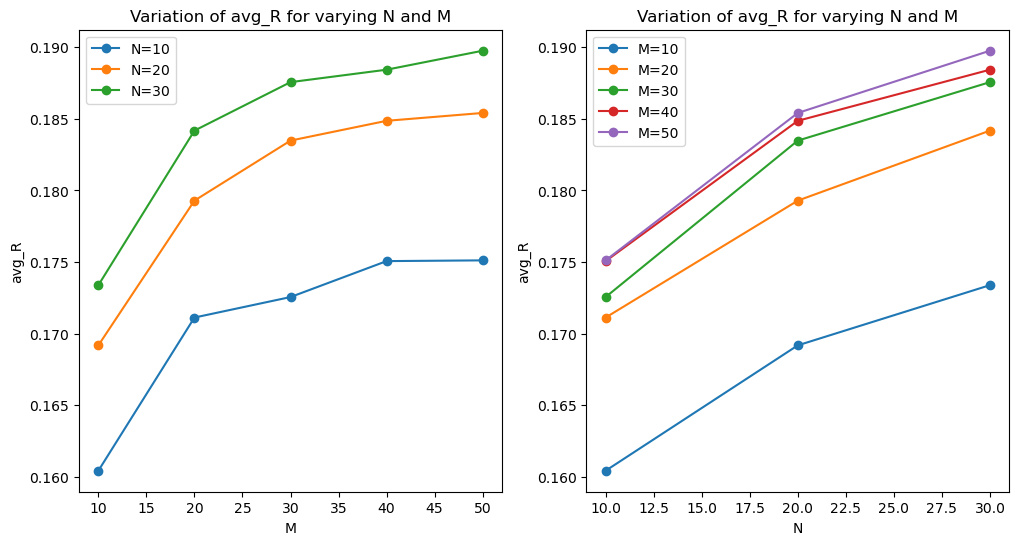

In [518]:
# plot as a function of M for avg_U and as a function of N fro avg_V
df = pd.DataFrame(data, columns = ['N', 'M', 'avg_R', 'avg_U', 'avg_V'])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for n in df['N'].unique():
    df_m = df[df['N'] == n]
    ax1.plot(df_m['M'], df_m['avg_R'], marker='o', label=f'N={n}')

for m in df['M'].unique():
    df_n = df[df['M'] == m]
    ax2.plot(df_n['N'], df_n['avg_R'], marker='o', label=f'M={m}')

ax1.set_xlabel('M')
ax1.set_ylabel('avg_R')
ax1.set_title('Variation of avg_R for varying N and M')
ax1.legend()

ax2.set_xlabel('N')
ax2.set_ylabel('avg_R')
ax2.set_title('Variation of avg_R for varying N and M')
ax2.legend()

plt.show()

In [ ]:
fig.savefig('avg_PMF_R.png')

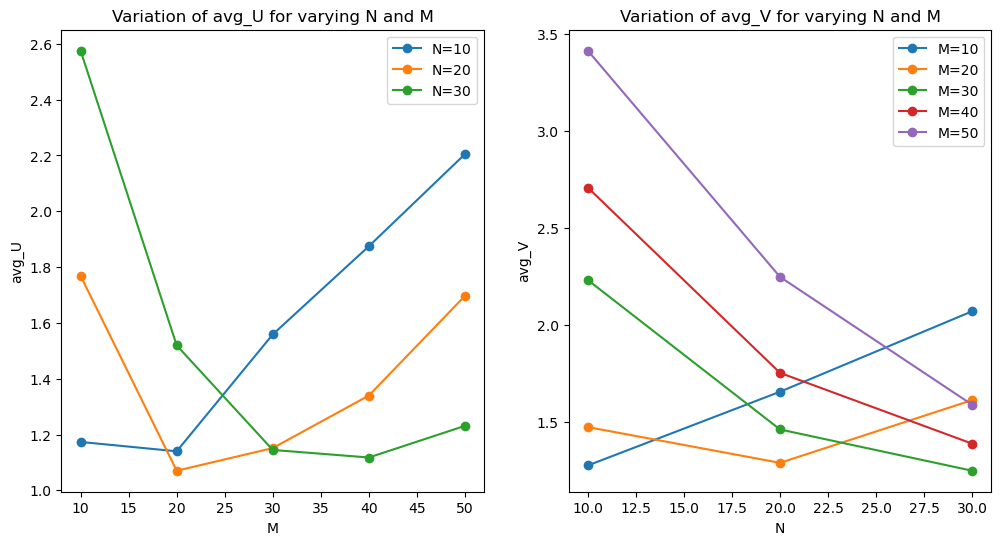

In [519]:
# plot as a function of M for avg_U and as a function of N for avg_V

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for n in df['N'].unique():
    df_m = df[df['N'] == n]
    ax1.plot(df_m['M'], df_m['avg_U'], marker='o', label=f'N={n}')
for m in df['M'].unique():
    df_n = df[df['M'] == m]
    ax2.plot(df_n['N'], df_n['avg_V'], marker='o', label=f'M={m}')

ax1.set_xlabel('M')
ax1.set_ylabel('avg_U')
ax1.set_title('Variation of avg_U for varying N and M')
ax1.legend()

ax2.set_xlabel('N')
ax2.set_ylabel('avg_V')
ax2.set_title('Variation of avg_V for varying N and M')
ax2.legend()

plt.show()

In [ ]:
fig.savefig('avg_PMF_U_V.png')

1.171911073692837
